#Sentiment Analysis using Word embedding and BiLSTM


#Exploratory Data Analysis

### Adding libraries

In [59]:
#pip install numpy==1.19.5

In [60]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow

#from tensorflow import keras
#gensim model for word2Vec
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#model creation
from keras import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt');
nltk.download('stopwords');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
from google.colab import drive

drive.mount('/content/gDrive/', force_remount=True)

Mounted at /content/gDrive/


In [62]:
DS1=pd.read_csv('/content/gDrive/My Drive/Colab/Dissertation/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)

In [63]:
DS1.head()

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [64]:
DS1=DS1[[5,0]]
DS1.columns=['tweets','sentiment']
DS1.head()

tweets  sentiment
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0
1  is upset that he can't update his Facebook by ...          0
2  @Kenichan I dived many times for the ball. Man...          0
3    my whole body feels itchy and like its on fire           0
4  @nationwideclass no, it's not behaving at all....          0

## Pre processing dataset

In [65]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('/content/gDrive/My Drive/Colab/Dissertation/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [66]:
DS1['tweets'] = DS1['tweets'].replace('!', ' exclamation ')
DS1['tweets'] = DS1['tweets'].replace('?', ' question ')
DS1['tweets'] = DS1['tweets'].replace('\'', ' quotation ')
DS1['tweets'] = DS1['tweets'].replace('\"', ' quotation ')

In [67]:
%%time
DS1['processed_text'] = DS1.tweets.apply(preprocess_apply)

CPU times: user 1min 18s, sys: 245 ms, total: 1min 19s
Wall time: 1min 18s


In [68]:
count=0
for row in DS1.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break


Text: 0
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: 0
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: 0
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: 0
Processed: my whole body feels itchy and like its on fire 
Text: 0
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all over there  
Text: 0
Processed: <user> not the whole crew 
Text: 0
Processed: need a hug 
Text: 0
Processed: <user> hey  long time no see  yes   rains a bit  only a bit  lol   i am fine thanks   how is you  
Text: 0
Processed: <user> nope they did not have it 
Text: 0
Processed: <user> que me muera   
Text: 0
Processed: spring break in plain city   it is snowing 


In [69]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  
0  <user> <url>   aww  thatis a bummer   you shou...  
1  is upset that he cannot update his facebook by...  
2  <user> i dived many times for the ball  manage...  
3    my whole body feels itchy and like its on fire   
4  <user> no  it is not behaving at all  i am mad...

Remove stopwords from pre processed text

In [70]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [71]:
DS1['tweet_without_stopwords'] = DS1['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [72]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [73]:
df2 = DS1.copy()

In [74]:
df2.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [75]:
#dropping duplicates
df2 = df2.drop_duplicates()

In [76]:
df2.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [77]:
df2["tweet_without_stopwords"] = df2["tweet_without_stopwords"].str.replace("<user>","")

In [78]:
df2["processed_text"] = df2["processed_text"].str.replace("<user>","")

In [79]:
df2.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0   <url>   aww  thatis a bummer   you shoulda go...   
1  is upset that he cannot update his facebook by...   
2   i dived many times for the ball  managed to s...   
3    my whole body feels itchy and like its on fire    
4   no  it is not behaving at all  i am mad  why ...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [80]:
df2['processed_text'].value_counts(dropna=False)

                                                                                                                                 2395
 get 100 followers a day using <url> once you add everyone you are on the train or pay vip                                       1447
 thanks                                                                                                                          1034
 thank you                                                                                                                        626
 thanks                                                                                                                           564
                                                                                                                                 ... 
awhh   no soccer for a while    blech   this sucks    but i had an amazing day                                                      1
 unfortunately  it would either have to be one of my contribut

##Basic wordcloud

In [23]:
processedtext = list(df2['tweet_without_stopwords'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

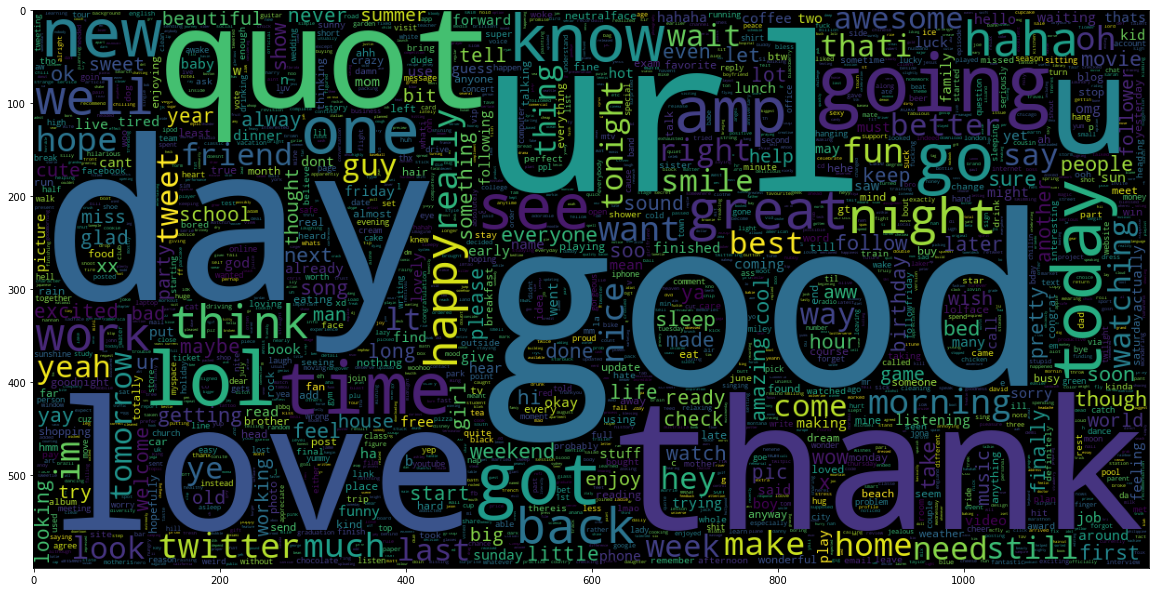

In [24]:
#wordcloud for positive tweets
wc = WordCloud(max_words = 100000 , width = 1200 , height = 600, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

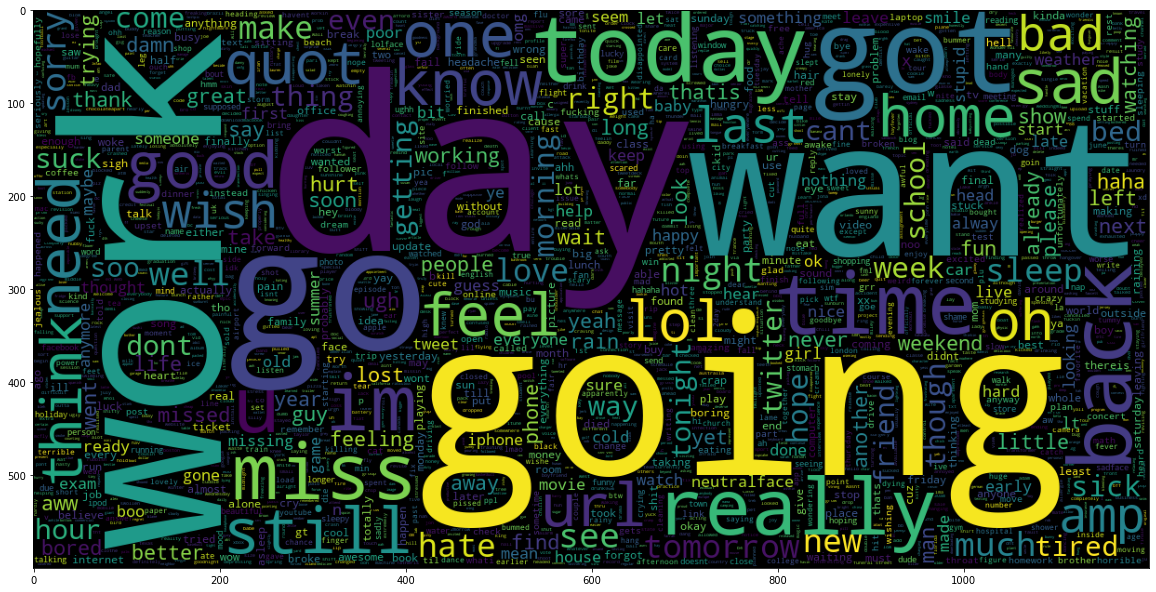

In [25]:
#wordcloud for negative tweets
wc = WordCloud(max_words = 100000 , width = 1200 , height = 600, collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

##Splitting data for analysis

In [26]:
#splitting data
from sklearn.model_selection import train_test_split

In [27]:
#taking the ratio 80:20
X_data, y_data = np.array(DS1['tweet_without_stopwords']), np.array(DS1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.1, random_state = 0)
print('Data Split is done.')

Data Split is done.


In [30]:
#!pip3 install --upgrade gensim --user
#we ran it once and restarted the timeline, so we are not going to do it again and again. once done, we will comment it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Checking Polarity of Tweets for dataset 1



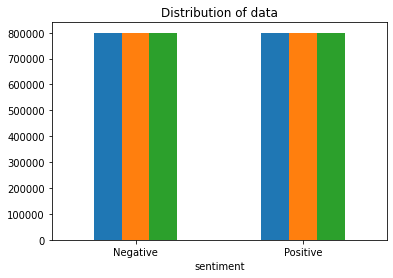

In [29]:
ax = DS1.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

##Using word2vec for model

In [31]:
#using gensim model

Embedding_dimensions = 1000

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [32]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 50220
CPU times: user 6min 4s, sys: 906 ms, total: 6min 5s
Wall time: 50.7 s


In [33]:
#tokeizing and padding datasets
# Defining the model input length. using tensorflow
input_length = 60

In [34]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


##Training the model

In [35]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1440000, 60)
X_test.shape : (160000, 60)


##Create embedding matrix

In [36]:
#create embed matrix
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 1000)


## Creating the Sentiment model

In [37]:
#placed in library section 

In [38]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [39]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 1000)          60000000  
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          880800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [40]:
#model training
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [41]:
#compile the model
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=5,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/5
1266/1266 [==============================] - 2509s 2s/step - loss: -1435346.2500 - accuracy: 0.0129 - val_loss: -5558863.5000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/5
1266/1266 [==============================] - 2493s 2s/step - loss: -17874316.0000 - accuracy: 0.0000e+00 - val_loss: -35346672.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/5
1266/1266 [==============================] - 2656s 2s/step - loss: -63918132.0000 - accuracy: 0.0000e+00 - val_loss: -98608888.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/5
1266/1266 [==============================] - 2363s 2s/step - loss: -146331040.0000 - accuracy: 0.0000e+00 - val_loss: -200349536.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/5
1266/1266 [==============================] - 2420s 2s/step - loss: -269045664.0000 - accuracy: 0.0000e+00 - val_loss: -344650048.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010


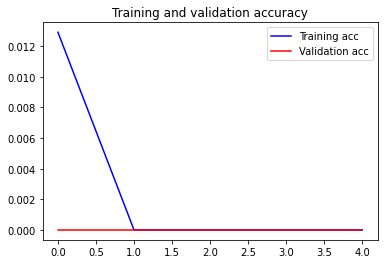

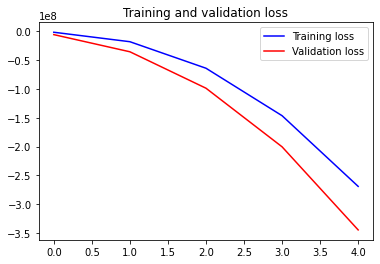

In [43]:
#evaluate the model
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## creating Confusion matrix for sentiment analysis

In [44]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Predicting model trained based on dataset

In [45]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 0, 1)
#y_pred.where(y_pred >= 0.5,1,0)

# Printing out the Evaluation metrics. Creates a problem, while creating a confusion matrix
#ConfusionMatrix(y_pred, y_test)

In [46]:
#from sklearn.svm import SVC
#clf = SVC(random_state=0)
#clf.fit(X_train, y_train)

In [47]:
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(clf,y_pred, y_test)
#plt.show()

In [48]:
#classification report
#Print the evaluation metrics for the dataset.
#print(classification_report(y_test, y_pred))

## Saving the model

In [49]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")

#Sentiment Analysis using ML algorithms (Bernoulli NB, Multinomial NB, Logistic regression)
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api (by author, i downloaded it from kaggle) . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.



In [50]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

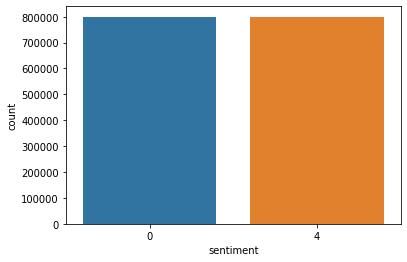

In [51]:
import seaborn as sns
sns.countplot(x="sentiment", data=DS1)

In [57]:
DS1.tail()

tweets  sentiment
1599995  Just woke up. Having no school is the best fee...          4
1599996  TheWDB.com - Very cool to hear old Walt interv...          4
1599997  Are you ready for your MoJo Makeover? Ask me f...          4
1599998  Happy 38th Birthday to my boo of alll time!!! ...          4
1599999  happy #charitytuesday @theNSPCC @SparksCharity...          4

In [53]:
DS1[['tweets','sentiment']].sample(10)

tweets  sentiment
251121            @zpush I'm trying lol - just frustrated           0
566386                                   Sitting in class           0
615387                       @mrtopp That is not a haiku.           0
1111614  Heidi and Tim on the cover of Enterainment Wee...          4
1511498        Saw the movie Role Models yesterday. Funny           4
1489604  heading downtown to do some sr pics for a fore...          4
1555402                    @maramonaco welcome to twitter           4
164359   @simonschuster Celebrity sighting: Spongebobs ...          0
884918   @bowbrick OpenDNS is good &amp; quick. filters...          4
363040   @SaraBrown26 I'm still at work, even now.  It ...          0

In [54]:
DS1 = DS1[['tweets','sentiment']]
DS1.describe()

sentiment
count  1.600000e+06
mean   2.000000e+00
std    2.000001e+00
min    0.000000e+00
25%    0.000000e+00
50%    2.000000e+00
75%    4.000000e+00
max    4.000000e+00

In [ ]:
#DS1['length'] = DS1['tweets'].apply(len)

In [ ]:
DS1[DS1['length'] == 74]['tweets'].iloc[0]

In [ ]:
DS1[DS1['length'] == 6]['tweets'].iloc[0]

In [ ]:
DS1[DS1['length'] == 70]['tweets'].iloc[0]

In [81]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [82]:
DS1["tweet_without_stopwords"] = DS1["tweet_without_stopwords"].str.replace("<user>","")

In [83]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [84]:
sentences = DS1['tweet_without_stopwords'].tolist()
sentences_string = " ".join(sentences)

### Word cloud visualization

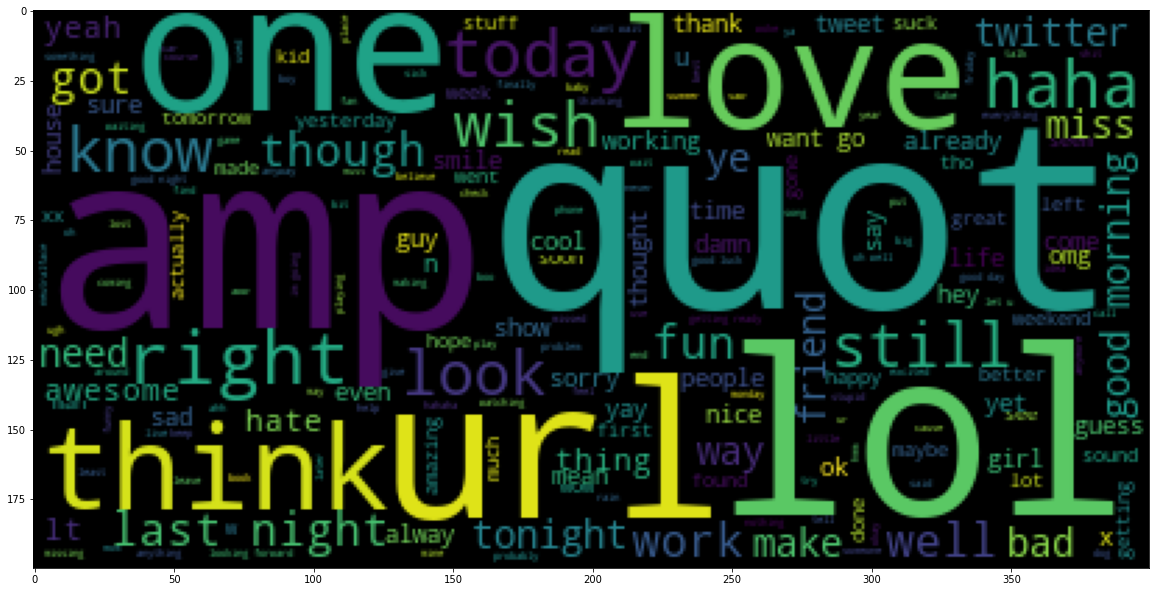

In [85]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_string))

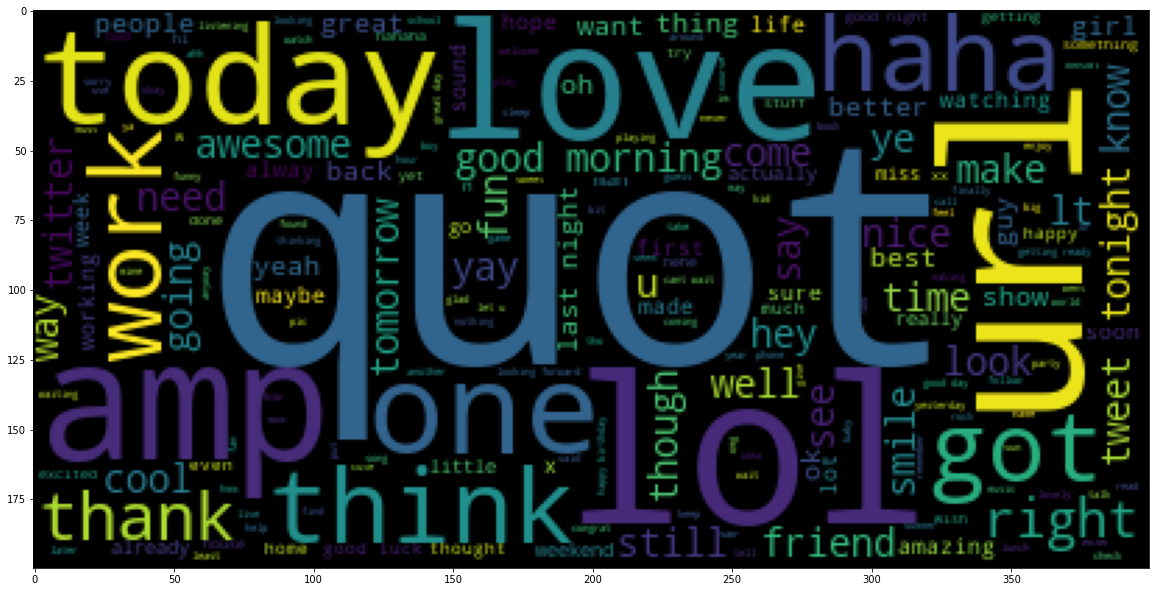

In [86]:
#positive tweets
sentences = DS1[DS1['sentiment'] == 4]['tweet_without_stopwords'].tolist()
sentences_string = " ".join(sentences)

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_string))

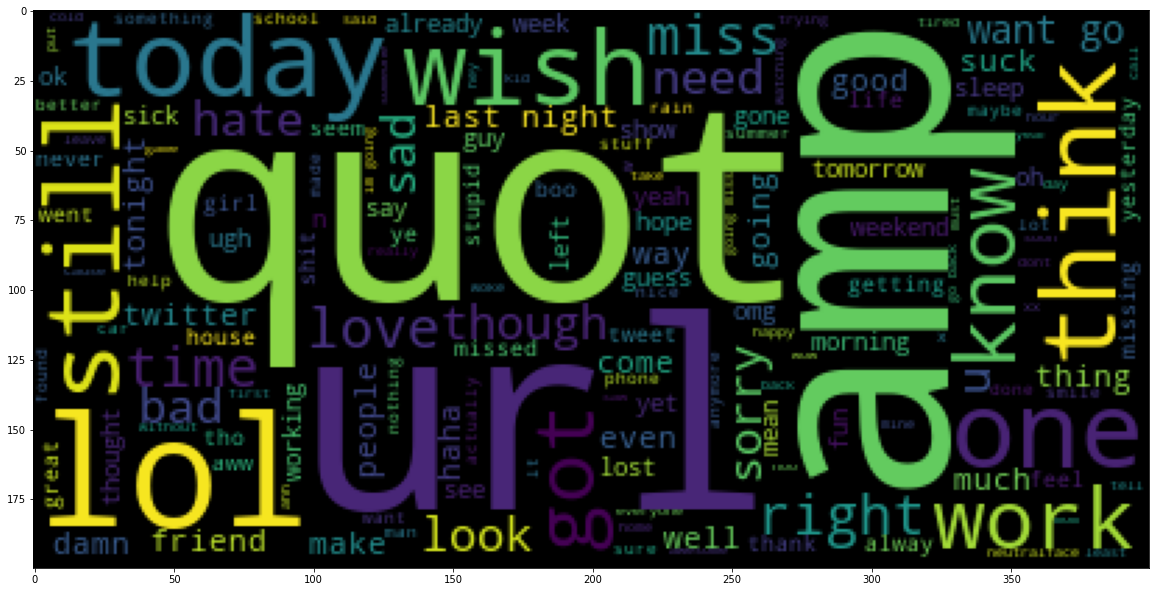

In [87]:
#negative tweets
sentences = DS1[DS1['sentiment'] == 0]['tweet_without_stopwords'].tolist()
sentences_string = " ".join(sentences)

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_string))

### ML algorithms used

In [88]:
import string
string.punctuation
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [89]:
def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [90]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = message_cleaning, dtype = 'uint8')
DS1_countvectorizer = vectorizer.fit_transform(DS1['tweet_without_stopwords'])

In [92]:
DS1_countvectorizer.shape

(1600000, 272177)

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DS1_countvectorizer, DS1['sentiment'],test_size = 0.25, random_state = 0)

In [94]:
X_train.shape

(1200000, 272177)

In [95]:
X_test.shape

(400000, 272177)

In [96]:
y_train.shape

(1200000,)

In [97]:
y_test.shape

(400000,)

In [98]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

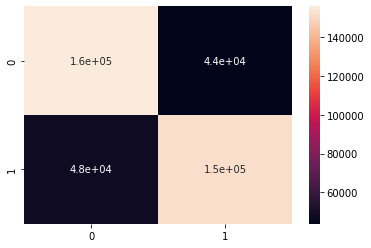

In [99]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [100]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77    199734
           4       0.78      0.76      0.77    200266

    accuracy                           0.77    400000
   macro avg       0.77      0.77      0.77    400000
weighted avg       0.77      0.77      0.77    400000



In [101]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)

BernoulliNB(alpha=2)

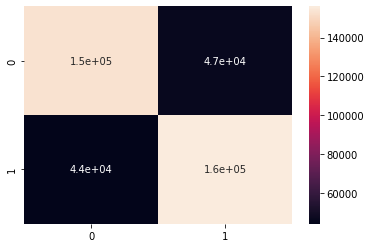

In [102]:
y_predict_test = BNBmodel.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [103]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77    199734
           4       0.77      0.78      0.77    200266

    accuracy                           0.77    400000
   macro avg       0.77      0.77      0.77    400000
weighted avg       0.77      0.77      0.77    400000



In [104]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C =2, max_iter=1000, n_jobs=1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=1)

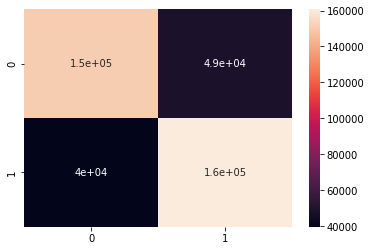

In [105]:
y_predict_test = LRmodel.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [106]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    199734
           4       0.77      0.80      0.78    200266

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000



#Most common words used

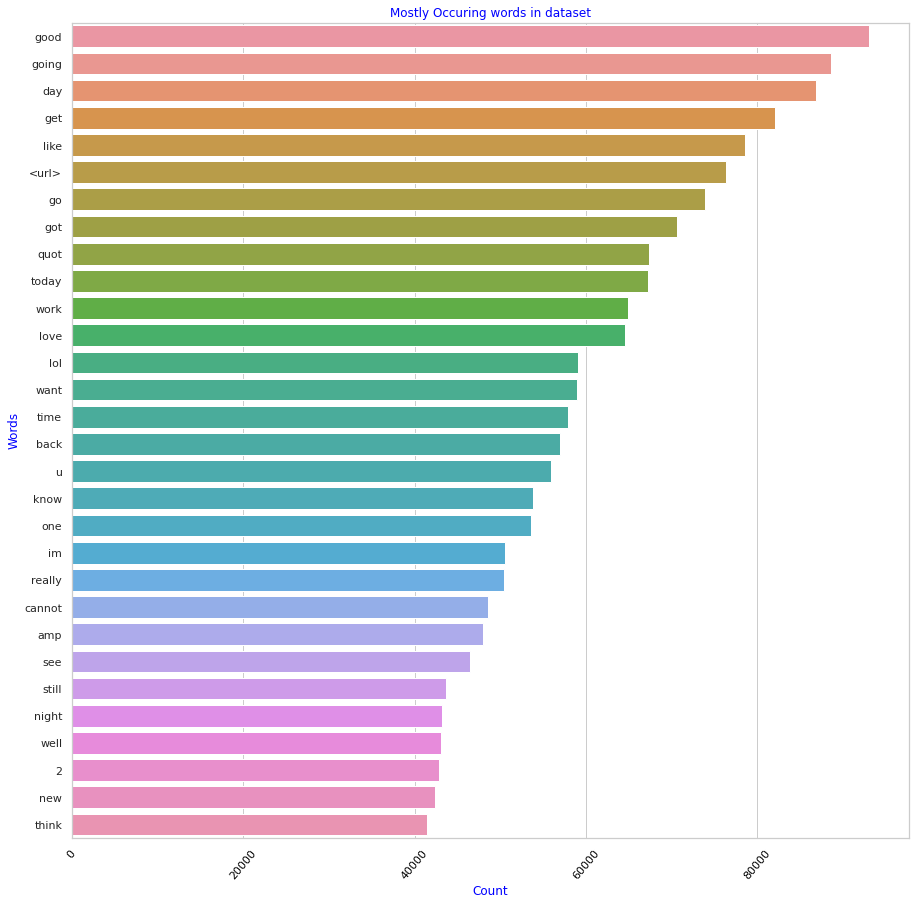

In [107]:
from collections import Counter #import Counter for finding most common words
import seaborn as sns #import searbon for vizualization result

text = DS1['tweet_without_stopwords']
words = text.str.split(expand=True).unstack()
result_count = Counter(words).most_common()
result_df = pd.DataFrame(result_count).reset_index().drop(0) #converting to Dataframe and drop the Nones values
#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 15)) 
sns.barplot(y=result_df[0][0:30], x=result_df[1][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Mostly Occuring words in dataset", color="blue") 
plt.xticks(rotation=50);
ax.tick_params(axis='x', colors='black')
plt.show()


#Considering negative words as sarcastic and finding out the most occuring words

In [108]:
#create DataFrame for non_sarcastic words 
non_sarcastic = pd.DataFrame(DS1[DS1['sentiment']==0]['tweet_without_stopwords'].str.split(expand=True).unstack().value_counts()).reset_index()

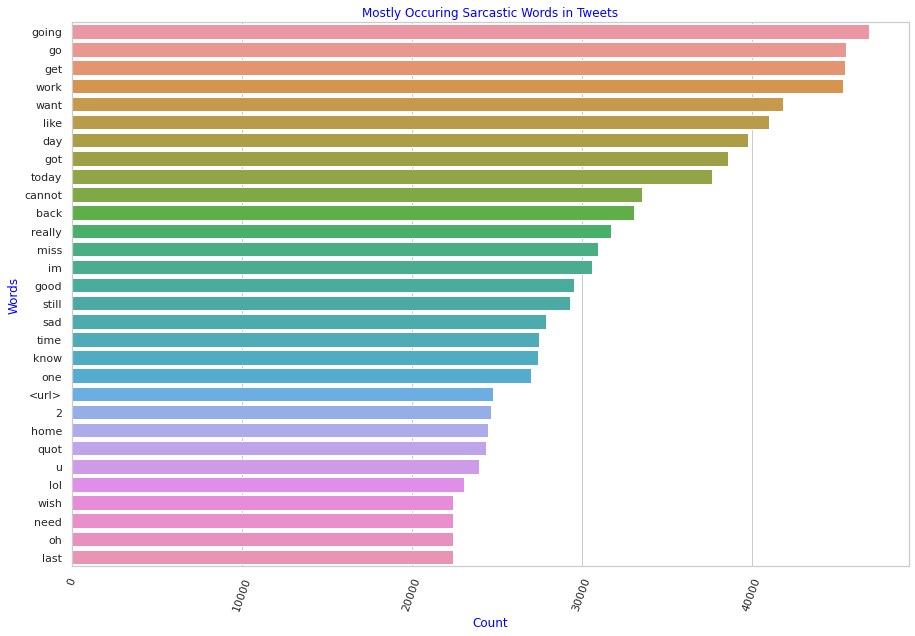

In [109]:
#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 10)) 
sns.barplot(y=non_sarcastic['index'][0:30], x=non_sarcastic[0][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Mostly Occuring Sarcastic Words in Tweets", color="blue") 
plt.xticks(rotation=70);
plt.show()


#Considering positive words as non -sarcastic and finding out the most occuring words

In [110]:
sarcastic = pd.DataFrame(DS1[DS1['sentiment']==4]['tweet_without_stopwords'].str.split(expand=True).unstack().value_counts()).reset_index()

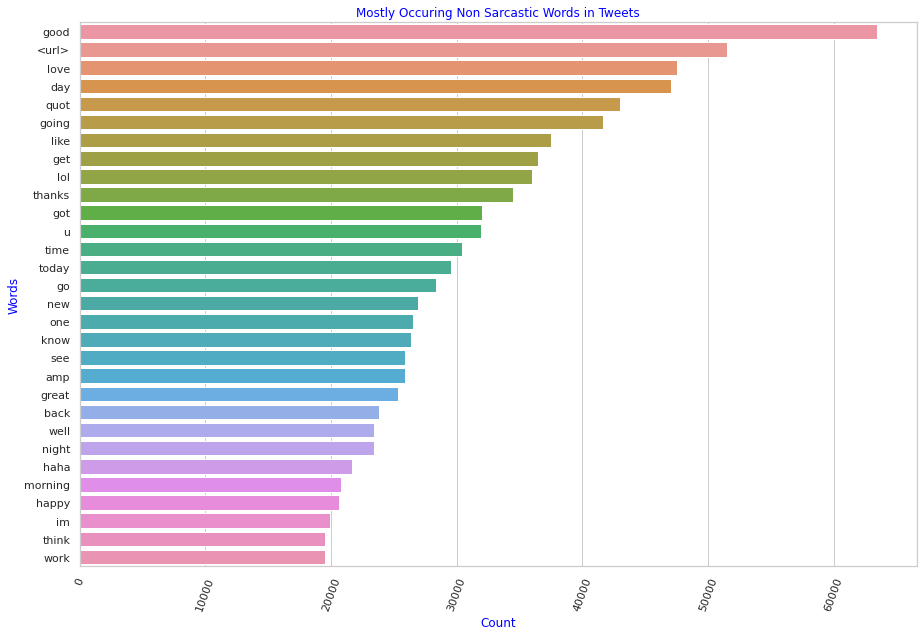

In [111]:
#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 10)) 
sns.barplot(y=sarcastic['index'][0:30], x=sarcastic[0][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Mostly Occuring Non Sarcastic Words in Tweets", color="blue") 
plt.xticks(rotation=70);
plt.show()

#Sarcasm detection with CNN, LSTM, Bi LSTM, Bi GRU

In [112]:
#Using Preprocessed data
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [113]:
DS1["tweet_without_stopwords"] = DS1["tweet_without_stopwords"].str.replace("<user>","")

In [114]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [115]:
#shuffle data to split into train, test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DS1['tweet_without_stopwords'], DS1['sentiment'], train_size = 0.7, random_state = 42, shuffle = True)

In [116]:
DS1.shape
train_dataframe = DS1[0:80000]
test_dataframe = DS1[80000:]

In [117]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1120000
1120000
480000
480000


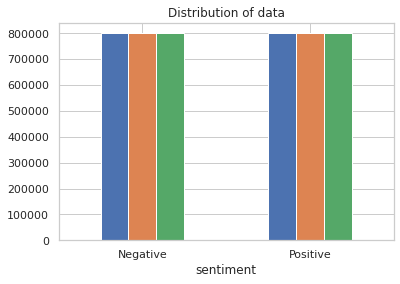

In [118]:
ax = DS1.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [119]:
#tokenize text
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 100
training_size = 80000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

In [120]:
#splitted data of 70:30 is used for training a simple model
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=5, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
35000/35000 - 156s - loss: -3.7167e+06 - accuracy: 0.0000e+00 - val_loss: -1.3570e+07 - val_accuracy: 0.0000e+00 - 156s/epoch - 4ms/step
Epoch 2/5
35000/35000 - 148s - loss: -4.3923e+07 - accuracy: 0.0000e+00 - val_loss: -8.9805e+07 - val_accuracy: 0.0000e+00 - 148s/epoch - 4ms/step
Epoch 3/5
35000/35000 - 146s - loss: -1.7209e+08 - accuracy: 0.0000e+00 - val_loss: -2.8009e+08 - val_accuracy: 0.0000e+00 - 146s/epoch - 4ms/step
Epoch 4/5
35000/35000 - 147s - loss: -4.3845e+08 - accuracy: 0.0000e+00 - val_loss: -6.3490e+08 - val_accuracy: 0.0000e+00 - 147s/epoch - 4ms/step
Epoch 5/5
35000/35000 - 146s - loss: -8.9327e+08 - accuracy: 0.0000e+00 - val_loss: -1.2046e+09 - val_accuracy: 0.0000e+00 - 146s/epoch - 4ms/step


##CNN model

In [121]:
#CNN Model
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history1 = model1.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
35000/35000 - 261s - loss: -3.7327e+10 - accuracy: 2.7679e-05 - val_loss: -1.6507e+11 - val_accuracy: 0.0000e+00 - 261s/epoch - 7ms/step
Epoch 2/10
35000/35000 - 337s - loss: -7.9502e+11 - accuracy: 0.0000e+00 - val_loss: -1.9110e+12 - val_accuracy: 0.0000e+00 - 337s/epoch - 10ms/step
Epoch 3/10
35000/35000 - 351s - loss: -4.5618e+12 - accuracy: 0.0000e+00 - val_loss: -8.4365e+12 - val_accuracy: 0.0000e+00 - 351s/epoch - 10ms/step
Epoch 4/10
35000/35000 - 291s - loss: -1.5374e+13 - accuracy: 0.0000e+00 - val_loss: -2.4642e+13 - val_accuracy: 0.0000e+00 - 291s/epoch - 8ms/step
Epoch 5/10
35000/35000 - 345s - loss: -3.8929e+13 - accuracy: 0.0000e+00 - val_loss: -5.7176e+13 - val_accuracy: 0.0000e+00 - 345s/epoch - 10ms/step
Epoch 6/10
35000/35000 - 279s - loss: -8.2721e+13 - accuracy: 0.0000e+00 - val_loss: -1.1437e+14 - val_accuracy: 0.0000e+00 - 279s/epoch - 8ms/step
Epoch 7/10
35000/35000 - 278s - loss: -1.5565e+14 - accuracy: 0.0000e+00 - val_loss: -2.0600e+14 - val_accura

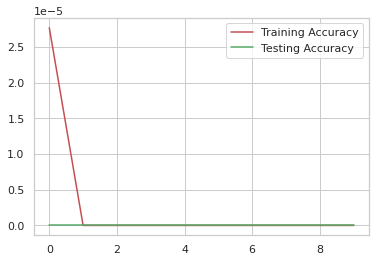

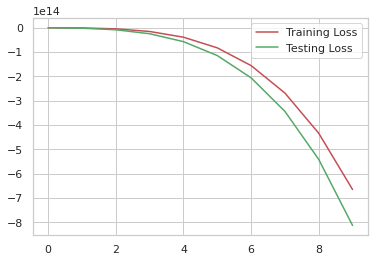

In [122]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

## LSTM model

In [123]:
#LSTM model
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [124]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 24)                1560      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [125]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history2 = model2.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
35000/35000 - 1399s - loss: -1.7609e+05 - accuracy: 0.0356 - val_loss: -5.0463e+05 - val_accuracy: 0.0524 - 1399s/epoch - 40ms/step
Epoch 2/10
35000/35000 - 1407s - loss: -1.1158e+06 - accuracy: 0.0651 - val_loss: -1.8797e+06 - val_accuracy: 0.0581 - 1407s/epoch - 40ms/step
Epoch 3/10
35000/35000 - 1373s - loss: -2.9158e+06 - accuracy: 0.0708 - val_loss: -4.1041e+06 - val_accuracy: 0.0378 - 1373s/epoch - 39ms/step
Epoch 4/10
35000/35000 - 1626s - loss: -5.5839e+06 - accuracy: 0.0743 - val_loss: -7.2094e+06 - val_accuracy: 0.0761 - 1626s/epoch - 46ms/step
Epoch 5/10
35000/35000 - 1491s - loss: -9.1141e+06 - accuracy: 0.0761 - val_loss: -1.1136e+07 - val_accuracy: 0.0802 - 1491s/epoch - 43ms/step
Epoch 6/10
35000/35000 - 1398s - loss: -1.3526e+07 - accuracy: 0.0912 - val_loss: -1.5978e+07 - val_accuracy: 0.0975 - 1398s/epoch - 40ms/step
Epoch 7/10
35000/35000 - 1476s - loss: -1.8797e+07 - accuracy: 0.0952 - val_loss: -2.1677e+07 - val_accuracy: 0.0839 - 1476s/epoch - 42ms/step

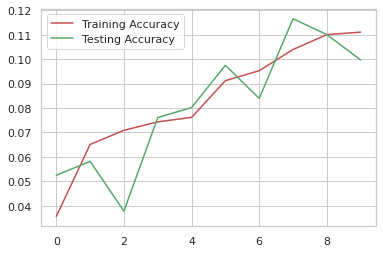

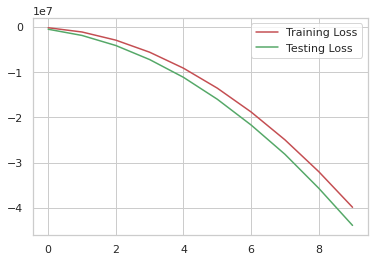

In [126]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

##Bi lstm

In [127]:
#Building the LSTM Model
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [128]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 164,429
Trainable params: 164,429
Non-trainable params: 0
_________________________________________________________________


In [129]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history3=model3.fit(training_padded, training_labels, batch_size=1000,epochs=10, verbose=2, validation_data=(testing_padded, testing_labels))

Epoch 1/10
1120/1120 - 271s - loss: -1.4697e+02 - accuracy: 0.0013 - val_loss: -4.0223e+02 - val_accuracy: 0.0079 - 271s/epoch - 242ms/step
Epoch 2/10
1120/1120 - 268s - loss: -8.1703e+02 - accuracy: 0.0121 - val_loss: -1.3399e+03 - val_accuracy: 0.0218 - 268s/epoch - 239ms/step
Epoch 3/10
1120/1120 - 264s - loss: -2.0035e+03 - accuracy: 0.0349 - val_loss: -2.7371e+03 - val_accuracy: 0.0369 - 264s/epoch - 235ms/step
Epoch 4/10
1120/1120 - 262s - loss: -3.5947e+03 - accuracy: 0.0536 - val_loss: -4.5069e+03 - val_accuracy: 0.0561 - 262s/epoch - 234ms/step
Epoch 5/10
1120/1120 - 263s - loss: -5.5525e+03 - accuracy: 0.0671 - val_loss: -6.6156e+03 - val_accuracy: 0.0782 - 263s/epoch - 235ms/step
Epoch 6/10
1120/1120 - 261s - loss: -7.8504e+03 - accuracy: 0.0812 - val_loss: -9.0651e+03 - val_accuracy: 0.0891 - 261s/epoch - 233ms/step
Epoch 7/10
1120/1120 - 261s - loss: -1.0471e+04 - accuracy: 0.0947 - val_loss: -1.1815e+04 - val_accuracy: 0.0964 - 261s/epoch - 233ms/step
Epoch 8/10
1120/1120

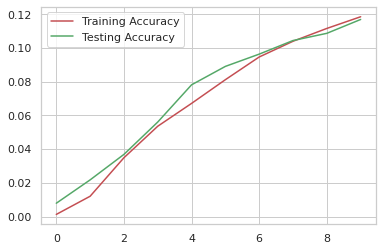

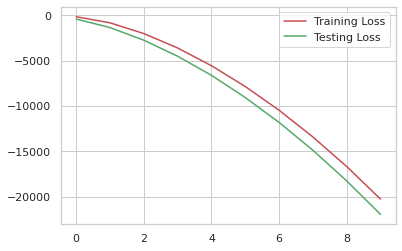

In [130]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

##Bidirectional GATED RECURRENT UNIT (GRU)

In [131]:
#Building the GRU Model
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [132]:
model4.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               3264      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 198       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 163,469
Trainable params: 163,469
Non-trainable params: 0
_________________________________________________________________


In [133]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history4=model4.fit(training_padded, training_labels, batch_size=1000,epochs=10, verbose=2, validation_data=(testing_padded, testing_labels))

Epoch 1/10
1120/1120 - 203s - loss: -1.7807e+02 - accuracy: 0.0258 - val_loss: -5.0732e+02 - val_accuracy: 0.0685 - 203s/epoch - 181ms/step
Epoch 2/10
1120/1120 - 194s - loss: -1.0851e+03 - accuracy: 0.0915 - val_loss: -1.7812e+03 - val_accuracy: 0.1102 - 194s/epoch - 173ms/step
Epoch 3/10
1120/1120 - 192s - loss: -2.6643e+03 - accuracy: 0.1154 - val_loss: -3.6430e+03 - val_accuracy: 0.1223 - 192s/epoch - 171ms/step
Epoch 4/10
1120/1120 - 194s - loss: -4.7911e+03 - accuracy: 0.1302 - val_loss: -6.0068e+03 - val_accuracy: 0.1221 - 194s/epoch - 173ms/step
Epoch 5/10
1120/1120 - 194s - loss: -7.4028e+03 - accuracy: 0.1379 - val_loss: -8.8140e+03 - val_accuracy: 0.1297 - 194s/epoch - 173ms/step
Epoch 6/10
1120/1120 - 194s - loss: -1.0472e+04 - accuracy: 0.1434 - val_loss: -1.2069e+04 - val_accuracy: 0.1429 - 194s/epoch - 173ms/step
Epoch 7/10
1120/1120 - 197s - loss: -1.3983e+04 - accuracy: 0.1477 - val_loss: -1.5739e+04 - val_accuracy: 0.1498 - 197s/epoch - 176ms/step
Epoch 8/10
1120/1120

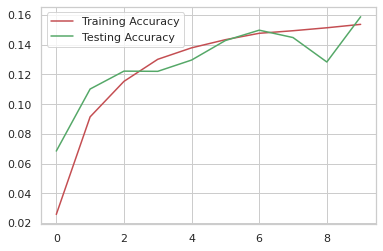

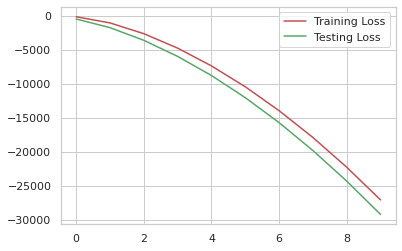

In [134]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history4.history['accuracy']
val_acc=history4.history['val_accuracy']
loss=history4.history['loss']
val_loss=history4.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

## Graphs of CNN/LSTM/BiLSTM/BiGRU based on accuracy

In [135]:
import pandas as pd
from pandas import DataFrame
accu = [max(history1.history['val_accuracy']),max(history2.history['val_accuracy']), max(history3.history['val_accuracy']), max(history4.history['val_accuracy'])]
loss = [max(history1.history['val_loss']),max(history2.history['val_loss']),max(history3.history['val_loss']), max(history4.history['val_loss'])]

col={'Accuracy':accu,'Loss':loss}
models=['CNN','LSTM','Bi LSTM', 'Bi GRU']
graph_df=DataFrame(data=col,index=models)
graph_df

Accuracy          Loss
CNN      0.000000 -1.650735e+11
LSTM     0.116512 -5.046270e+05
Bi LSTM  0.116931 -4.022331e+02
Bi GRU   0.158865 -5.073179e+02

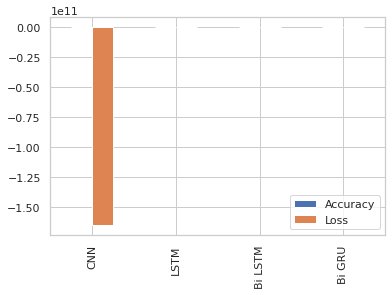

In [136]:
graph_df.plot(kind='bar')